In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from IPython import display


In [534]:
#loading the data and loosing all Null values
df = pd.read_csv(r'framingham_heart_disease.csv')
df = df[['male', 'heartRate', 'sysBP', 'totChol', 'BMI']]
original_size = df.shape[0]
df.dropna(how='any', inplace=True)
no_null_size = df.shape[0]
df.insert(loc=0, column='intercept', value=1)
print(f'Data size after dropping Null values is'
      f' {no_null_size / original_size * 100:0.3}% of the original data size')

Data size after dropping Null values is 98.4% of the original data size


In [535]:
def generate_sample(df, size):
    np.random.seed(4861351)
    flag = True
    sample = None
    while flag:  #will take another sample if there is one sex only
        sample = df.sample(size)
        female_count, male_count = sample[['male', 'BMI']].groupby('male').count()['BMI']
        if female_count != 0 and male_count != 0:
            if abs(female_count - male_count) <= size * 0.1:
                flag = False
            else:
                flag = True
    return sample

Q1

In [536]:
sample = generate_sample(df, 1000)
X_variables = ['intercept', 'heartRate', 'sysBP', 'totChol']
y_variable = 'BMI'
X = df[X_variables]
y = df[y_variable]
X_sample = sample[X_variables]
y_sample = sample[y_variable]

beta_dict = {}

In [537]:
z_alpha = stats.norm.ppf(0.975)
def calculate_beta(X, y):
    # Calculate MLE
    C = X.T @ X
    C_inv = np.linalg.inv(C)
    C_inv_X = C_inv @ X.T
    beta = C_inv_X @ y
    return np.round(beta, 4).to_numpy()


def beta_CI(X, y, beta_sample, x_variables):
    n = X.shape[0]
    p = X.shape[1]
    C = np.linalg.inv(X.T @ X)
    e = y - np.dot(X, beta_sample)  #residuals
    res_var_estimate = (1 / (n - p)) * (e.T @ e)  #sigma-hat squared
    CI = []
    for i, variable in enumerate(x_variables):
        std_estimate = np.sqrt(res_var_estimate * (C[i][i]))  #SE of Beta_i
        CI.append(np.round([beta_sample[i] - z_alpha * std_estimate,
                            beta_sample[i] + z_alpha * std_estimate], 4))
    return CI

Q2

In [538]:
beta_sample = calculate_beta(X_sample, y_sample)
regular_CI = beta_CI(X_sample, y_sample, beta_sample, X_variables)
print(f'Beta = {beta_sample}')
for i in range(beta_sample.size):
    print(f"CI for beta_{i} is: {regular_CI[i]}")
beta_dict['full/no missing'] = beta_sample

Beta = [16.9997  0.0046  0.0578  0.0031]
CI for beta_0 is: [14.7841 19.2153]
CI for beta_1 is: [-0.0165  0.0257]
CI for beta_2 is: [0.0461 0.0695]
CI for beta_3 is: [-0.0025  0.0087]


Q3

In [539]:
argsort_y = np.argsort(sample['BMI'])
BMI_missing = []

for record, idx in zip(sample['BMI'], argsort_y):
    p = 0.2 + (0.0006 * idx)
    missing = np.random.binomial(1, p)
    if missing == 0:
        BMI_missing.append(record)
    else:
        BMI_missing.append(None)

sample['BMI_missing'] = BMI_missing

Q4.a

In [540]:
X_missing = X_sample[sample['BMI_missing'].isnull()==False]
y_missing = y_sample[sample['BMI_missing'].isnull()==False]
beta_missing = calculate_beta(X_missing, y_missing)
CI_missing = beta_CI(X_missing, y_missing, beta_missing, X_variables)
print(f'Beta = {beta_missing}')
for i in range(beta_missing.size):
    print(f"CI for beta_{i} is: {CI_missing[i]}")
beta_dict['seen data'] = beta_missing

Beta = [15.287   0.0048  0.0591  0.0096]
CI for beta_0 is: [12.0055 18.5685]
CI for beta_1 is: [-0.0245  0.0341]
CI for beta_2 is: [0.0422 0.076 ]
CI for beta_3 is: [0.0011 0.0181]


REGRESSION IMPUTATION - Q4.b

In [541]:
sample['intercept'] = np.ones_like(sample['BMI'])
sample_full= sample[['intercept','heartRate', 'totChol', 'sysBP', 'BMI_missing']][sample['BMI_missing'].isnull()==False]
X = sample[['intercept','heartRate', 'totChol', 'sysBP']].to_numpy()
X_full = sample_full[['intercept','heartRate', 'totChol', 'sysBP']].to_numpy()
y_full= sample_full[['BMI_missing']].to_numpy()
full_model = sm.OLS(y_full,X_full).fit()

beta_full = full_model.params #reggression coefficients
missing_BMI_reg = np.round(full_model.predict(X),2)
BMI_regression_imputation = [missing_BMI_reg[i] if pd.isnull(sample['BMI_missing'].iloc[i])
                             else sample['BMI_missing'].iloc[i]
                             for i in range(sample.shape[0])]
sample['BMI_regression'] = BMI_regression_imputation
#we need to make a new regression model now
#calcultate CI
#do the results similar between this Q and the previous one
y_regression= sample['BMI_regression'].to_numpy()
model = sm.OLS(y_regression,X).fit()
beta_regression = model.params
print(f'{beta_regression} = beta estimator based on regression imputation')
beta_dict['regression imputation'] = beta_regression

[15.28741  0.00478  0.00956  0.05915] = beta estimator based on regression imputation


MULTIPLE IMPUTATION - Q4.c

In [542]:
M=500
sd_estimator = full_model.mse_resid**0.5
beta_mat = []
var_mat = np.zeros((M,4))
C = np.linalg.inv(X.T @ X)
for m in range(M):
    BMI_mul = np.array([np.random.normal(BMI_regression_imputation[i], sd_estimator, size=1)
                              if pd.isnull(sample['BMI_missing'].iloc[i])
                            else sample['BMI_missing'].iloc[i] for i in range(len(BMI_regression_imputation))])

    model = sm.OLS(BMI_mul,X).fit()
    for i in range(4):
        var_mat[m][i] = model.mse_resid * C[i][i]
    beta_mat.append(np.concatenate(model.params))
beta_multiple = np.average(beta_mat,axis=0)
print(f'{beta_multiple} = beta estimator based on multiple imputation') # the other way
beta_dict['multiple imputation'] = beta_multiple

C:\Users\yogev\AppData\Local\Temp\ipykernel_9064\1995964081.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  BMI_mul = np.array([np.random.normal(BMI_regression_imputation[i], sd_estimator, size=1)


[15.20087  0.00476  0.0098   0.05936] = beta estimator based on multiple imputation


RUBIN VARIANCE ESTIMATOR FOR BETAS - Q4.d

In [543]:
rubin_var = np.zeros(4)
beta_mat_avg = np.average(var_mat,axis=0)
beta_difference = np.average((beta_mat - beta_multiple)**2,axis=0)

for i in range(4):
    rubin_var[i] = beta_mat_avg[i] + ((M+1)/(M-1))*beta_difference[i]
print(f'{rubin_var} = Rubin variance for beta')
print(f'{np.round(beta_multiple,2)} = beta estimator based on multiple imputation') # the other way
for i in range(4):
    CI = np.round([beta_multiple[i] - z_alpha*np.sqrt(rubin_var[0]),
          beta_multiple[i] + z_alpha*np.sqrt(rubin_var[1])],2)
    print(f'CI for beta {i} with se based on Rubin variance: {CI}')


[2.08065 0.00018 0.00001 0.00006] = Rubin variance for beta
[15.2   0.    0.01  0.06] = beta estimator based on multiple imputation
CI for beta 0 with se based on Rubin variance: [12.37 15.23]
CI for beta 1 with se based on Rubin variance: [-2.82  0.03]
CI for beta 2 with se based on Rubin variance: [-2.82  0.04]
CI for beta 3 with se based on Rubin variance: [-2.77  0.09]


LOGISTIC REGRESSION - Q4.e

In [544]:
np.set_printoptions(suppress=True, precision=5)

R = [0 if np.isnan(record) else 1 for record in sample['BMI_missing']] # indicators for missing values
sample['R'] = R
reg = LogisticRegression(penalty="none",fit_intercept=False).fit(X,R)
estimated_beta = reg.coef_[0]
print(f'The estimator for beta is:{estimated_beta}')
print(f'The probability E[Y|X] = P(R=1|X_1,...X_k) = (1+exp(-1*<{estimated_beta}, [1,X_1,...,X_k]>))^-1')

The estimator for beta is:[-0.41847  0.00868  0.00104 -0.00344]
The probability E[Y|X] = P(R=1|X_1,...X_k) = (1+exp(-1*<[-0.41847  0.00868  0.00104 -0.00344], [1,X_1,...,X_k]>))^-1


C:\Users\yogev\anaconda3\envs\stat2_prj5\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LEAST SQUARES IPW ESTIMATOR - Q4.f

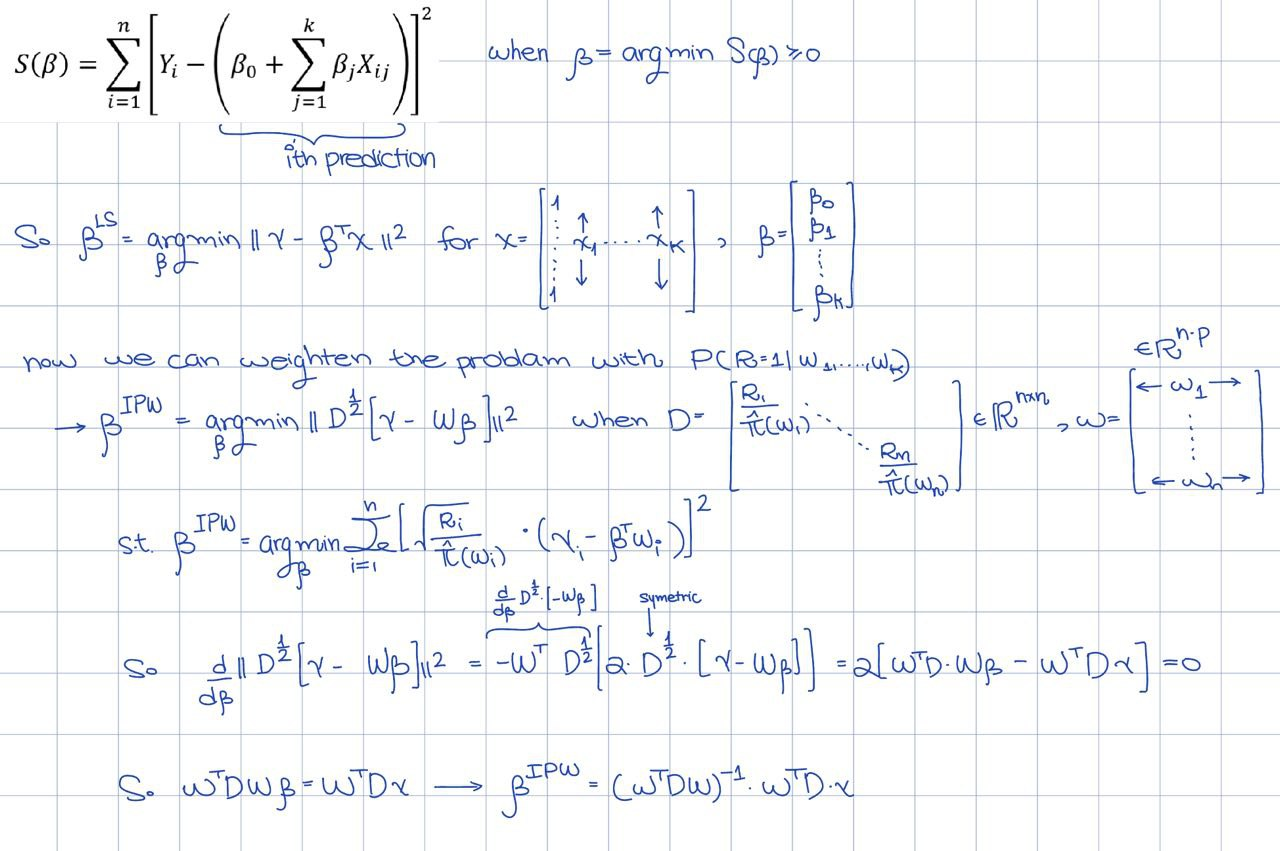

In [545]:
display.Image('LS_IPW.jpg')

In [546]:
def pi(beta_dot_x):
    return np.exp(beta_dot_x)/(1+np.exp(beta_dot_x))

In [547]:
D_vals = [1/pi(np.dot(estimated_beta,x)) for x in X]
D = np.diag(D_vals)
y_reg = sample['BMI_regression']
Xt_D_X = np.matmul(X.T,np.matmul(D,X))
Xt_D_X_inv = np.linalg.inv(Xt_D_X)
Xt_D = np.matmul(X.T,D)
Xt_D_y = np.matmul(Xt_D,y_reg)
beta_IPW = np.matmul(Xt_D_X_inv,Xt_D_y)
print(f'The estimator for beta using IPW is:{beta_IPW}')
beta_dict['IPW'] = beta_IPW

The estimator for beta using IPW is:[15.27553  0.00547  0.00954  0.05889]


BOOTSTRAP CI - Q4.g

In [548]:
B=100
n=X.shape[0]
beta_bootstrap_mat = np.zeros((B,4))

for b in range(B):
    bootstrap_df = sample.sample(n, replace = True).reset_index(drop=True)
    bootstrap_X = bootstrap_df[X_variables].to_numpy()
    bootstrap_y = bootstrap_df['BMI_regression'].to_numpy()

    D_vals = [1/pi(np.dot(estimated_beta,x)) for x in bootstrap_X]
    D = np.diag(D_vals)
    Xt_D_X = np.matmul(bootstrap_X.T,np.matmul(D,bootstrap_X))
    Xt_D_X_inv = np.linalg.inv(Xt_D_X)
    Xt_D = np.matmul(bootstrap_X.T,D)
    Xt_D_y = np.matmul(Xt_D,bootstrap_y)
    beta_IPW = np.matmul(Xt_D_X_inv,Xt_D_y)

    beta_bootstrap_mat[b] = beta_IPW

print(f'The estimator for beta using IPW is:{beta_IPW}')
for i,col in enumerate(beta_bootstrap_mat.T):
    CI = np.quantile(col, [0.025, 0.975])
    print(f'CI for beta_{i} based on quantiles is {CI}')


The estimator for beta using IPW is:[15.28982  0.0103   0.06231  0.00636]
CI for beta_0 based on quantiles is [13.78379 17.32569]
CI for beta_1 based on quantiles is [-0.01229  0.02025]
CI for beta_2 based on quantiles is [0.04764 0.06925]
CI for beta_3 based on quantiles is [0.00477 0.01317]


In [550]:
# beta_pd = pd.DataFrame(beta_dict, columns = X_variables,
#                          index = ["full data", "no missing data", "regression imputation", "multiple imputation", "IPW"])
# beta_pd

,intercept,heartRate,sysBP,totChol
full data,NaN,NaN,NaN,NaN
no missing data,NaN,NaN,NaN,NaN
regression imputation,NaN,NaN,NaN,NaN
multiple imputation,NaN,NaN,NaN,NaN
IPW,NaN,NaN,NaN,NaN
